In [1]:
import numpy as np
import pandas as pd
import torch as th
import os
from typing import Callable
from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import EvalCallback, CheckpointCallback, StopTrainingOnNoModelImprovement
from stable_baselines3.common.vec_env import VecNormalize, DummyVecEnv
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.utils import set_random_seed
from forex_envNew import ForexEnv
from bnn_policy import BNNActorCriticPolicy

# ✅ 修复：设置随机种子
SEED = 42
set_random_seed(SEED, using_cuda=True)
np.random.seed(SEED)
th.manual_seed(SEED)


In [2]:

def create_data_splits(df: pd.DataFrame, train_ratio: float = 0.7, val_ratio: float = 0.15):
    """
    ✅ 新增：正确的时序数据分割，避免数据泄露
    """
    n = len(df)
    train_end = int(n * train_ratio)
    val_end = int(n * (train_ratio + val_ratio))
    
    df_train = df.iloc[:train_end].copy()
    df_val = df.iloc[train_end:val_end].copy()
    df_test = df.iloc[val_end:].copy()
    
    print(f"📊 数据分割:")
    print(f"   训练集: {len(df_train):,} 行 ({train_ratio*100:.0f}%)")
    print(f"   验证集: {len(df_val):,} 行 ({val_ratio*100:.0f}%)")
    print(f"   测试集: {len(df_test):,} 行 ({(1-train_ratio-val_ratio)*100:.0f}%)")
    
    return df_train, df_val, df_test


In [3]:

# ✅ 主程序开始
print("🚀 开始训练 BNN-PPO 外汇交易模型")
print("=" * 50)

# 1. 加载和预处理数据
print("📂 加载数据...")
df = pd.read_csv('./data/2024min1.csv', index_col=0, parse_dates=True)

# ✅ 更保守的数据使用策略
data_size = min(10000, len(df))  # 限制数据大小，避免内存问题
df = df.iloc[-data_size:].copy()  # 使用最新数据
df.reset_index(inplace=True)

print(f"   原始数据: {len(df):,} 行")

# 2. 特征工程
print("🔧 特征工程...")
from featuresNew import add_features
df = add_features(df)
print(f"   处理后: {len(df):,} 行, {len(df.columns)} 列")

# ✅ 3. 正确的数据分割
df_train, df_val, df_test = create_data_splits(df)



🚀 开始训练 BNN-PPO 外汇交易模型
📂 加载数据...
   原始数据: 10,000 行
🔧 特征工程...
🔧 开始特征工程...
   计算RCI指标...
   添加时间特征...
   使用窗口大小: 100
   清理特征...
✅ 特征工程完成！
   - 数据长度: 10000 → 9901 (丢弃 99 行)
   - 特征维度: 25
   - 核心特征: ['RCI9', 'RCI14', 'RCI21', 'Volatility', 'MA50_Ratio', 'close_norm', 'volume_norm', 'High_Low_Range', 'Bayesian_Prob']
   处理后: 9,901 行, 25 列
📊 数据分割:
   训练集: 6,930 行 (70%)
   验证集: 1,485 行 (15%)
   测试集: 1,486 行 (15%)


In [ ]:

def create_learning_rate_schedule(initial_lr: float = 3e-4, warmup_steps: int = 10000, decay_factor: float = 0.5, total_timesteps = 100000) -> Callable[[float], float]:
    """
    ✅ 改进：学习率调度器
    """
    def schedule(progress_remaining: float) -> float:
        # 计算当前步数
        current_step = int((1 - progress_remaining) * total_timesteps)
        
        # 预热阶段
        if current_step < warmup_steps:
            return initial_lr * (current_step / warmup_steps)
        
        # 余弦退火
        decay_progress = (current_step - warmup_steps) / (total_timesteps - warmup_steps)
        return initial_lr * (decay_factor + (1 - decay_factor) * 0.5 * (1 + np.cos(np.pi * decay_progress)))
    
    return schedule

def test_environment_safety(env_class, df_sample: pd.DataFrame):
    """
    ✅ 新增：环境安全性测试
    """
    print("🧪 开始环境安全性测试...")
    
    test_env = env_class(df_sample, max_position=0.3)
    obs, _ = test_env.reset()
    
    issues = []
    
    for i in range(min(100, len(df_sample) - test_env.lookback - 10)):
        action = test_env.action_space.sample()
        
        try:
            obs, reward, terminated, truncated, info = test_env.step(action)
            
            # 检查数值稳定性
            if np.any(np.isnan(obs)) or np.any(np.isinf(obs)):
                issues.append(f"步骤 {i}: 观测包含 NaN/Inf")
            
            if np.isnan(reward) or np.isinf(reward):
                issues.append(f"步骤 {i}: 奖励为 NaN/Inf: {reward}")
                
            if info['net_worth'] <= 0:
                issues.append(f"步骤 {i}: 净值为负或零: {info['net_worth']}")
                
            if terminated or truncated:
                break
                
        except Exception as e:
            issues.append(f"步骤 {i}: 异常 {str(e)}")
            break
    
    if issues:
        print("⚠️ 发现环境问题:")
        for issue in issues[:5]:  # 只显示前5个问题
            print(f"   - {issue}")
        if len(issues) > 5:
            print(f"   - ... 还有 {len(issues) - 5} 个问题")
        return False
    else:
        print("✅ 环境安全性测试通过!")
        return True

In [30]:

# 4. 环境安全性测试
if not test_environment_safety(ForexEnv, df_train.iloc[:5000]):
    print("❌ 环境测试失败，请检查代码")
    exit(1)

# 5. 创建训练环境
print("🏗️ 创建训练环境...")
train_env = ForexEnv(
    df_train, 
    max_position=0.25,  # ✅ 更保守的仓位限制
    cost_ratio=0.0002,  # ✅ 更现实的交易成本
    trade_penalty=0.0005,  # ✅ 减少过度交易
)
train_env = Monitor(train_env, filename="logs/train_monitor.csv")

# 6. 创建验证环境（独立数据）
print("🔍 创建验证环境...")
eval_env = ForexEnv(
    df_val, 
    max_position=0.25,
    cost_ratio=0.0002,
    trade_penalty=0.0005,
)
eval_env = Monitor(eval_env, filename="logs/eval_monitor.csv")

🧪 开始环境安全性测试...
✅ 环境安全性测试通过!
🏗️ 创建训练环境...
🔍 创建验证环境...


In [31]:

# 7. 向量化环境
train_vec_env = DummyVecEnv([lambda: train_env])
train_vec_env = VecNormalize(
    train_vec_env,
    norm_obs=True,
    norm_reward=True,
    gamma=0.99,
    clip_obs=10.0,
    epsilon=1e-8,  # ✅ 数值稳定性
)

eval_vec_env = DummyVecEnv([lambda: eval_env])
eval_vec_env = VecNormalize(
    eval_vec_env,
    norm_obs=True,
    norm_reward=False,  # ✅ 评估时不标准化奖励
    gamma=0.99,
    clip_obs=10.0,
    training=False,  # ✅ 评估环境不更新统计量
    epsilon=1e-8,
)

In [32]:

# ✅ 8. 设置训练参数
total_timesteps = 100000  # 增加训练步数
print(f"🎯 总训练步数: {total_timesteps:,}")

# 9. 创建回调函数
os.makedirs("logs", exist_ok=True)
os.makedirs("checkpoints", exist_ok=True)

# 提前停止
stop_callback = StopTrainingOnNoModelImprovement(
    max_no_improvement_evals=5,  # ✅ 更宽松的停止条件
    min_evals=10,
    verbose=1
)

# 评估回调
eval_callback = EvalCallback(
    eval_vec_env,
    best_model_save_path="./logs/",
    log_path="./logs/",
    eval_freq=15000,  # ✅ 更频繁的评估
    deterministic=True,
    callback_after_eval=stop_callback,
    n_eval_episodes=3,  # ✅ 多轮评估求平均
    verbose=1,
)

# 检查点保存
checkpoint_callback = CheckpointCallback(
    save_freq=30000,
    save_path="./checkpoints/",
    name_prefix="bnn_ppo_forex",
    verbose=1,
)


🎯 总训练步数: 100,000


In [35]:

# ✅ 10. 创建模型（优化超参数）
print("🤖 创建 PPO 模型...")

model = PPO(
    policy=BNNActorCriticPolicy,
    env=train_vec_env,
    verbose=1,
    tensorboard_log="./bnn_ppo_log/",
    learning_rate=create_learning_rate_schedule(2e-4, 15000, 0.3, total_timesteps = total_timesteps),  # ✅ 更低学习率
    batch_size=512,        # ✅ 增大批次
    n_steps=2048,          # ✅ 增大步数
    gamma=0.995,           # ✅ 更重视长期奖励
    gae_lambda=0.95,       # ✅ 平衡偏差和方差
    ent_coef=0.005,        # ✅ 减少熵正则化
    clip_range=0.15,       # ✅ 更保守的裁剪
    n_epochs=8,            # ✅ 增加训练轮数
    max_grad_norm=1.0,     # ✅ 梯度裁剪
    vf_coef=0.5,           # ✅ 价值函数权重
    target_kl=0.02,        # ✅ 更严格的KL散度限制
    device="cuda" if th.cuda.is_available() else "cpu",
    seed=SEED,
    policy_kwargs={
        'log_std_init': -2.0,      # ✅ 更保守的策略初始化
        'ortho_init': True,
        'activation_fn': th.nn.ReLU,
        'net_arch': [dict(pi=[256, 256, 128], vf=[256, 256, 128])],  # ✅ 优化网络结构
        'share_features_extractor': False,  # ✅ 策略和价值网络独立特征提取
    }
)

print(f"💻 使用设备: {model.device}")
print("🏋️ 模型参数统计:")
total_params = sum(p.numel() for p in model.policy.parameters())
trainable_params = sum(p.numel() for p in model.policy.parameters() if p.requires_grad)
print(f"   总参数: {total_params:,}")
print(f"   可训练参数: {trainable_params:,}")

🤖 创建 PPO 模型...
Using cpu device
💻 使用设备: cpu
🏋️ 模型参数统计:
   总参数: 431,620
   可训练参数: 431,620


c:\Users\annen\AppData\Local\Programs\Python\Python313\Lib\site-packages\stable_baselines3\common\policies.py:486: UserWarning: As shared layers in the mlp_extractor are removed since SB3 v1.8.0, you should now pass directly a dictionary and not a list (net_arch=dict(pi=..., vf=...) instead of net_arch=[dict(pi=..., vf=...)])
  warnings.warn(


In [36]:

# ✅ 11. 开始训练
print("\n" + "=" * 50)
print("🚀 开始训练...")
print("=" * 50)

try:
    model.learn(
        total_timesteps=total_timesteps,
        callback=[eval_callback, checkpoint_callback],
        tb_log_name=f"BNN_PPO_{SEED}",
        progress_bar=True,
        reset_num_timesteps=False
    )
    
    print("✅ 训练成功完成!")
    
except KeyboardInterrupt:
    print("\n⚠️ 训练被中断，保存当前模型...")
    
except Exception as e:
    print(f"\n❌ 训练出错: {e}")
    import traceback
    traceback.print_exc()


🚀 开始训练...
Logging to ./bnn_ppo_log/BNN_PPO_42_0

❌ 训练出错: You must install tqdm and rich in order to use the progress bar callback. It is included if you install stable-baselines with the extra packages: `pip install stable-baselines3[extra]`


Traceback (most recent call last):
  File "C:\Users\annen\AppData\Local\Temp\ipykernel_29296\3906091776.py", line 7, in <module>
    model.learn(
    ~~~~~~~~~~~^
        total_timesteps=total_timesteps,
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    ...<3 lines>...
        reset_num_timesteps=False
        ^^^^^^^^^^^^^^^^^^^^^^^^^
    )
    ^
  File "c:\Users\annen\AppData\Local\Programs\Python\Python313\Lib\site-packages\stable_baselines3\ppo\ppo.py", line 311, in learn
    return super().learn(
           ~~~~~~~~~~~~~^
        total_timesteps=total_timesteps,
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    ...<4 lines>...
        progress_bar=progress_bar,
        ^^^^^^^^^^^^^^^^^^^^^^^^^^
    )
    ^
  File "c:\Users\annen\AppData\Local\Programs\Python\Python313\Lib\site-packages\stable_baselines3\common\on_policy_algorithm.py", line 311, in learn
    total_timesteps, callback = self._setup_learn(
                                ~~~~~~~~~~~~~~~~~^
        total_timesteps,
        ^^^

In [ ]:

# 12. 保存模型和环境参数
print("💾 保存模型...")
model.save("bnn_ppo_forex_final")
train_vec_env.save("train_vec_normalize.pkl")
eval_vec_env.save("eval_vec_normalize.pkl")

# ✅ 13. 保存测试数据（用于后续评估）
print("📊 保存测试数据...")
df_test.to_csv("data/test_data.csv")

print("\n" + "=" * 50)
print("✅ 训练流程完成!")
print("=" * 50)
print("📊 查看训练日志:")
print(f"   TensorBoard: tensorboard --logdir=./bnn_ppo_log/")
print(f"   监控文件: logs/train_monitor.csv")
print("🚀 运行评估:")
print(f"   python evaluate.py")
print("=" * 50)

In [44]:

# 在 evaluate.py 末尾添加此函数
def plot_trading_signals(df,  save_path="trading_signals.png"):
    """
    绘制交易信号叠加在价格图上
    """
    import matplotlib.pyplot as plt
    from matplotlib.patches import Rectangle

    fig, ax1 = plt.subplots(figsize=(16, 8))


    # 1. 绘制价格曲线
    ax1.plot(df['timestamp'], df['close'], label='EUR/USD Price', color='red', alpha=0.9, linewidth=1)

    # 4. 设置标签和标题
    ax1.set_title('EUR/USD Trading Signals with PPO + BNN Strategy', fontsize=16)
    ax1.set_xlabel('Time Index')
    ax1.set_ylabel('Price', fontsize=12)
    ax1.legend(loc='upper left')
    ax1.grid(True, alpha=0.3)

    fig, ax2 = plt.subplots(figsize=(16, 8))


    # 1. RCI曲线
    ax2.plot(df['timestamp'], df['RCI21'], label='RCI21', color='blue', alpha=0.9, linewidth=1)


    # 4. 设置标签和标题
    ax2.set_title('EUR/USD Trading Signals with PPO + BNN Strategy', fontsize=16)
    ax2.set_ylabel('RCI21', fontsize=12)
    ax2.legend(loc='upper left')
    ax2.grid(True, alpha=0.3)

    ax3 = ax1.twinx()
    ax3.plot(df['timestamp'], df['RCI21'], label='RCI21', color='blue', alpha=0.9, linewidth=1)


    # 4. 设置标签和标题
    ax3.set_ylabel('RCI21', fontsize=12)
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    # 5. 保存并显示图表
    plt.tight_layout()
    plt.savefig(save_path, dpi=150)
    plt.show()

    print(f"✅ 交易信号图已保存: {save_path}")



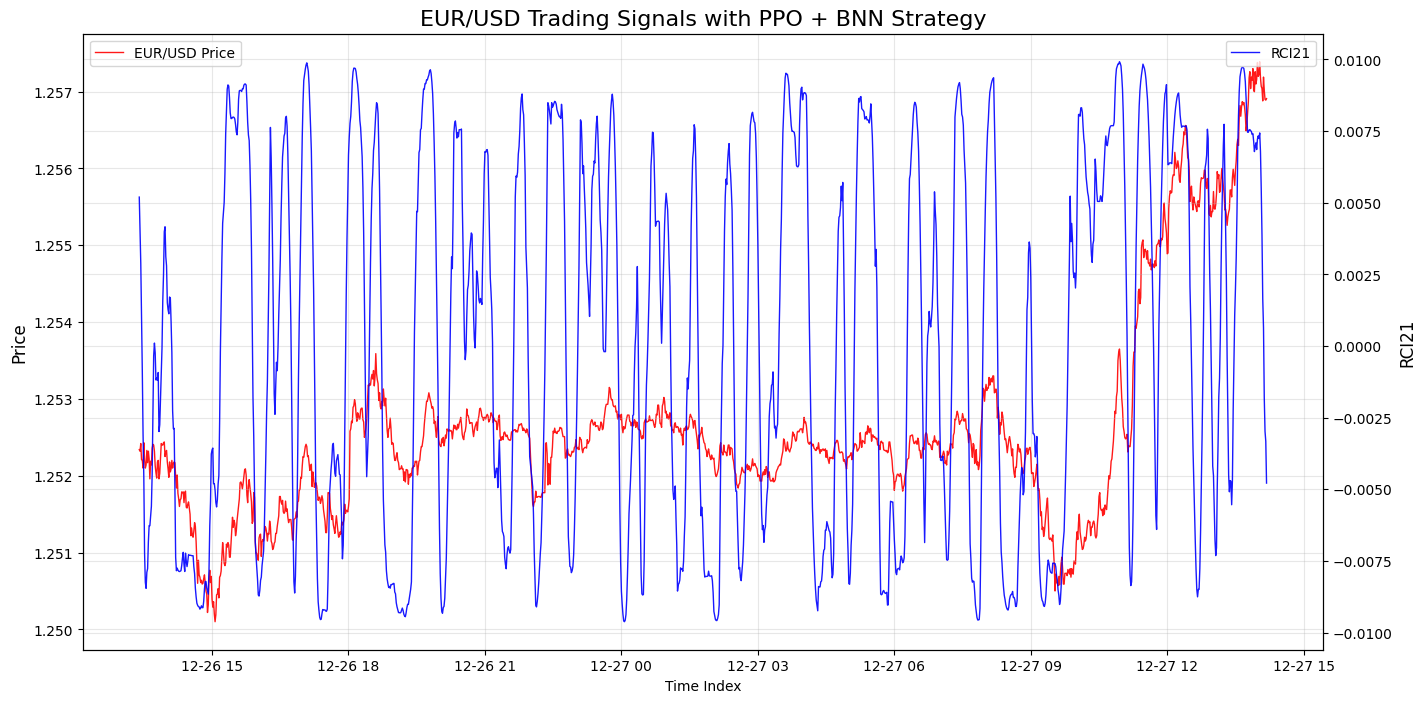

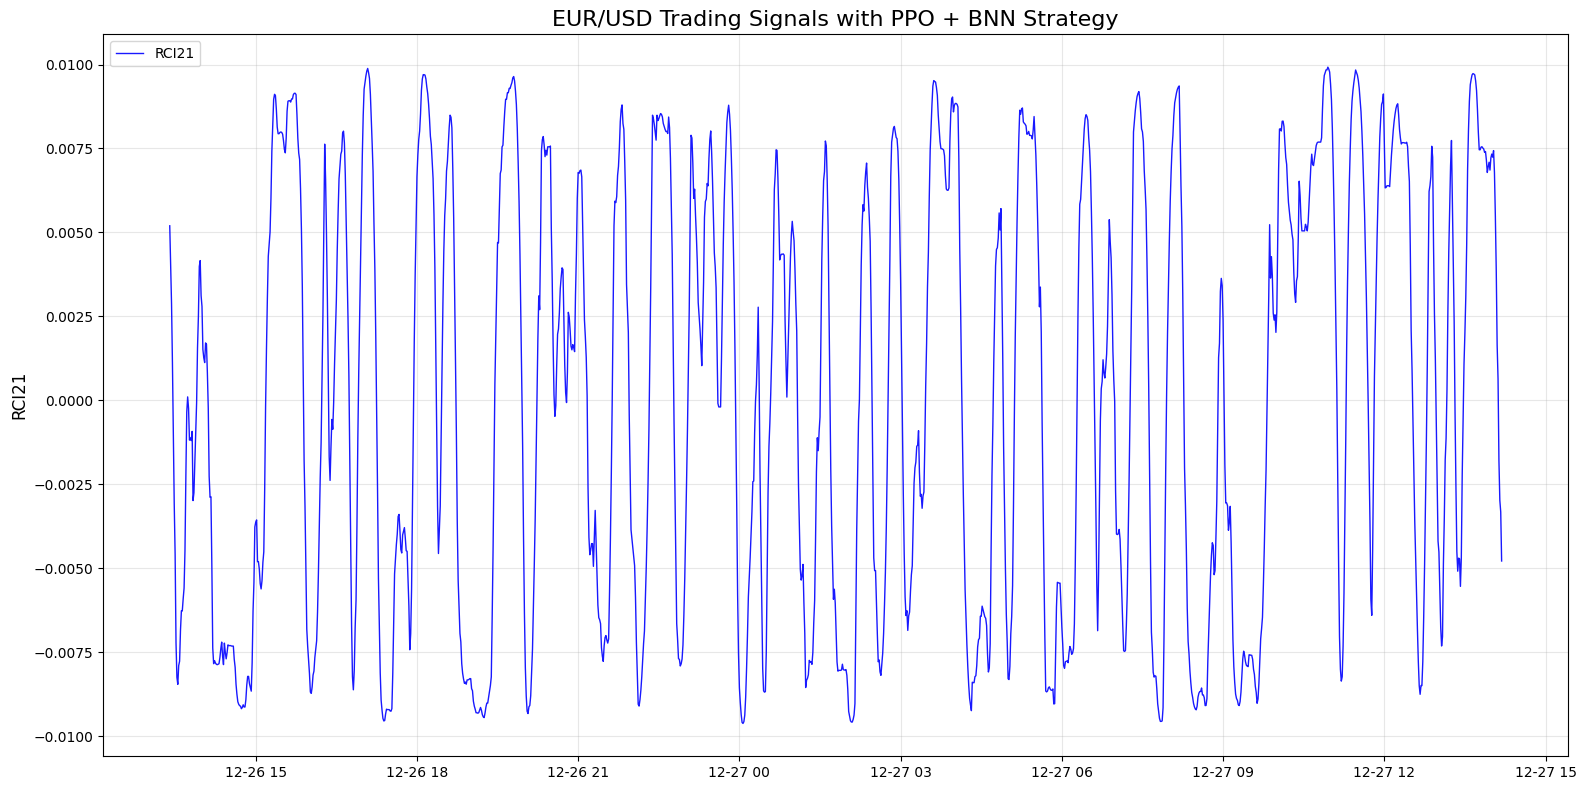

✅ 交易信号图已保存: trading_signals.png


In [45]:
plot_trading_signals(df_val)